In [1]:
import fnmatch
import os
import random
import cv2

import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import ipywidgets as wg
import scipy.interpolate as interp
import scipy.signal as signal
import matplotlib.animation as animation

from matplotlib.image import imread
from tqdm.notebook import tqdm
from ipywidgets import interactive
from scipy import ndimage
from scipy.spatial import distance
from scipy.stats import gaussian_kde

%matplotlib inline

## Helpers

In [2]:
IMAGE_PATH = 'data/images/'
FIXATION_PATH = 'data/fixations/'
MAP_PATH = 'data/maps/'
WMAP_PATH = 'data/weighted_maps/'
WFIX_PATH = 'data/weighted_fixations/'
GT_SLICE_PATH = 'data/3-sliced_maps/'
MDSEM_GT_SLICE_PATH = 'data/3-sliced_mdsem_maps/'
FIX_SLICE_PATH = 'data/3-sliced_fixations/'

TRAIN_PATH = 'train/'
VAL_PATH = 'val/'
TEST_PATH = 'test/'

TRAINING_SIZE = 10000
MDSEM_SIZE = 500

W = 640
H = 480
TIMESPAN = 5000

In [3]:
def create_fixation_map(fix):
    fix_map = np.zeros(shape=(W,H))
    for coord in fix:
        fix_map[coord[0] - 1, coord[1] - 1] = 1
        
    return fix_map.T

In [4]:
def create_weighted_fixation_map(fix):
    fix_map = np.zeros(shape=(W,H))
    for w, coord in fix:
        fix_map[coord[0] - 1, coord[1] - 1] = max(w, fix_map[coord[0] - 1, coord[1] - 1])
        
    return fix_map.T

In [5]:
def create_image(fix, filter_size=19):
    return ndimage.filters.gaussian_filter(create_fixation_map(fix), filter_size)

In [6]:
def create_weighted_image(fix, filter_size=19, threshold=0.1):
    fix_map = np.zeros(shape=(W,H))
    for w, coord in fix:
        fix_map[coord[0] - 1, coord[1] - 1] = max(w, fix_map[coord[0] - 1, coord[1] - 1])
    
    fix_map = fix_map.T
    conv_image = ndimage.filters.gaussian_filter(fix_map, filter_size)
    conv_image /= conv_image.max()    
    fix_conv = np.where(fix_map != 0, conv_image, 0)
    fix_map = (fix_conv > threshold).astype(float)
    
    return conv_image, ndimage.filters.gaussian_filter(fix_map, filter_size), fix_map

In [7]:
def get_filenames(path):
    return [file for file in sorted(os.listdir(path)) if fnmatch.fnmatch(file, 'COCO_*')]

In [8]:
MAX_PIXEL_DISTANCE = np.linalg.norm([W, H])
ESTIMATED_TIMESTAMP_WEIGHT = 0.006

def get_saliency_volumes(filenames, 
                         path_prefix=TRAIN_PATH,
                         etw=ESTIMATED_TIMESTAMP_WEIGHT, progress_bar=True):
    saliency_volumes = []
    errors = []
    
    filenames = tqdm(filenames) if progress_bar else filenames

    for filename in filenames:
        # 1. Extracting data from .mat files
        mat = sio.loadmat(FIXATION_PATH + path_prefix + filename)
        gaze = mat["gaze"]

        locations = []
        timestamps = []
        fixations = []

        for i in range(len(gaze)):
            locations.append(mat["gaze"][i][0][0])
            timestamps.append(mat["gaze"][i][0][1])
            fixations.append(mat["gaze"][i][0][2])

        # 2. Matching fixations with timestamps
        saliency_volume = []
        for i, observer in enumerate(fixations):
            fix_timestamps = []
            fix_time = TIMESPAN / (len(observer) + 1)
            est_timestamp = 0

            for fixation in observer:
                distances = distance.cdist([fixation], locations[i], 'euclidean')[0][..., np.newaxis]
                time_diffs = abs(timestamps[i] - est_timestamp)
                min_idx = np.argmin(etw * time_diffs + distances)

                fix_timestamps.append([min(timestamps[i][min_idx][0], TIMESPAN), fixation.tolist()])
                errors.append(distances[min_idx])
                est_timestamp += fix_time

            if (len(observer) > 0):
                saliency_volume.append(fix_timestamps)

        saliency_volumes.append(saliency_volume)

    return saliency_volumes, np.mean(errors) / MAX_PIXEL_DISTANCE

In [9]:
def split_fixations(fix_timestamps, splitters):
    split_at = fix_timestamps[:,0].searchsorted(splitters)
    return np.split(fix_timestamps[:,1], split_at)

In [10]:
def get_heat_image(image):
    return cv2.cvtColor(cv2.applyColorMap(np.uint8(255 * image), cv2.COLORMAP_HOT), cv2.COLOR_BGR2RGB)

In [11]:
RATIO = 0.9

def format_image(heatmap, image, max_value):
    extended_map = heatmap / max_value
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    factors = np.clip(2 * extended_map, 0, 1)
    hsv[:,:,1] = np.uint8(factors * hsv[:,:,1])
    hsv[:,:,2] = np.uint8((RATIO * factors + (1 - RATIO)) * hsv[:,:,2])
    
    return get_heat_image(extended_map[:,:,np.newaxis]), cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

In [12]:
def display_images(maps, image, normalized=False):
    f, axarr = plt.subplots(2, len(maps), figsize=(24, 8))
    max_value = np.max(maps);
    
    for i in range(len(maps)):
        heatmap, image_heatmap = format_image(maps[i], image, np.max(maps[i]) if normalized else max_value)
        axarr[0,i].imshow(heatmap)
        axarr[1,i].imshow(image_heatmap)

In [13]:
def display_interactive(maps, image, normalized=False):
    plt.ion()
    max_value = np.max(maps);
    formatted_images = []
    for map in maps:
        heatmap, image_heatmap = format_image(map, image, np.max(map) if normalized else max_value)
        formatted_images.append((heatmap, image_heatmap))
    
    f, axarr = plt.subplots(1, 2, figsize=(13, 6))
    axim1 = axarr[0].imshow(formatted_images[0][0])
    axim2 = axarr[1].imshow(formatted_images[0][1])
    
    def action(i):
        axim1.set_data(formatted_images[i][0])
        axim2.set_data(formatted_images[i][1])
        plt.draw()

    image_slider = interactive(action, i=wg.IntSlider(min=0, max=len(maps) - 1, step=1))
    output = image_slider.children[-1]
    return image_slider

In [14]:
def animate(maps, image, normalized=False):
    fig = plt.figure(figsize=(13, 6))
    max_value = np.max(maps);
    formatted_images = []
    
    for map in maps:
        heatmap, image_heatmap = format_image(map, image, np.max(map) if normalized else max_value)
        im = plt.imshow(np.concatenate((heatmap, image_heatmap), 1), animated=True)
        formatted_images.append([im])

    return animation.ArtistAnimation(fig, formatted_images, interval=200, blit=True, repeat_delay=1000)

In [15]:
def CC(gtsAnn, resAnn):
    """
    Computer CC score. A simple implementation
    :param gtsAnn : ground-truth fixation map
    :param resAnn : predicted saliency map
    :return score: int : score
    """

    fixationMap = gtsAnn - np.mean(gtsAnn)
    if np.max(fixationMap) > 0:
        fixationMap = fixationMap / np.std(fixationMap)
    salMap = resAnn - np.mean(resAnn)
    if np.max(salMap) > 0:
        salMap = salMap / np.std(salMap)

    return np.corrcoef(salMap.reshape(-1), fixationMap.reshape(-1))[0][1]

# 3-Sliced ground truth

In [16]:
index = random.randint(0, MDSEM_SIZE - 1)

gt_filename = get_filenames(MDSEM_GT_SLICE_PATH + TRAIN_PATH + '500/')[index]
ground_truths = [cv2.resize(imread(MDSEM_GT_SLICE_PATH + TRAIN_PATH + '500/' + gt_filename), 
                            dsize=(W,H), interpolation=cv2.INTER_CUBIC),
                cv2.resize(imread(MDSEM_GT_SLICE_PATH + TRAIN_PATH + '3000/' + gt_filename), 
                           dsize=(W,H), interpolation=cv2.INTER_CUBIC),
                cv2.resize(imread(MDSEM_GT_SLICE_PATH + TRAIN_PATH + '5000/' + gt_filename), 
                           dsize=(W,H), interpolation=cv2.INTER_CUBIC)]

saliency_volume = get_saliency_volumes([gt_filename[:-3] + 'mat'], progress_bar=False)[0][0]
image = imread(IMAGE_PATH + TRAIN_PATH + gt_filename[:-3] + 'jpg')

fix_timestamps = np.array(sorted([fixation for fix_timestamps in saliency_volume
                                  for fixation in fix_timestamps], key=lambda x: (x[0])))
maps = [create_image(bucket) for bucket in 
        split_fixations(fix_timestamps, [1000, 2500, 3500, 4000])[0::2]]

print('Cumulated number of fixations:', fix_timestamps.shape[0])

Cumulated number of fixations: 486


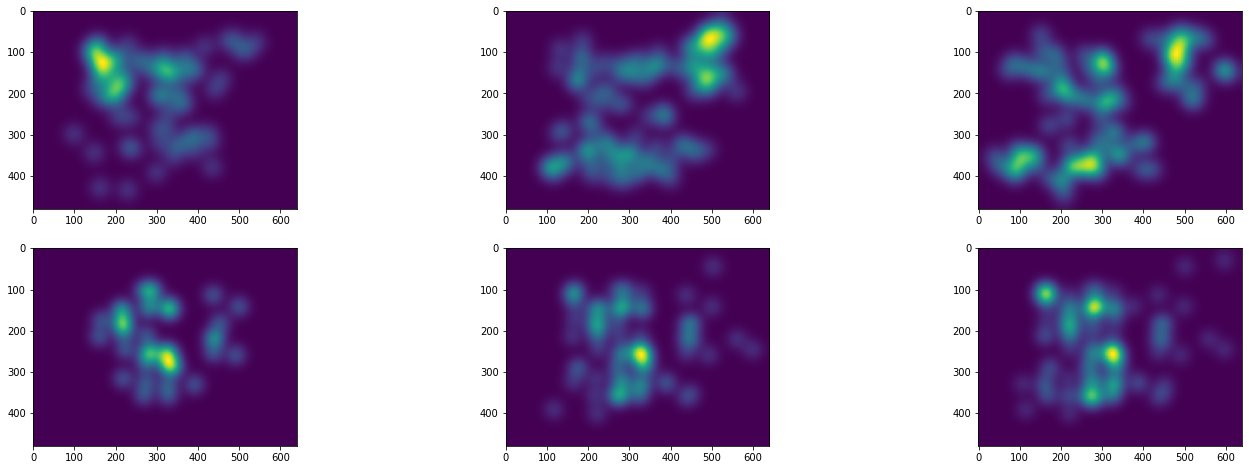

In [17]:
f, axarr = plt.subplots(2, 3, figsize=(24, 8))

for i in range(3):
    axarr[0,i].imshow(maps[i])
    
for i in range(3):
    axarr[1,i].imshow(ground_truths[i])

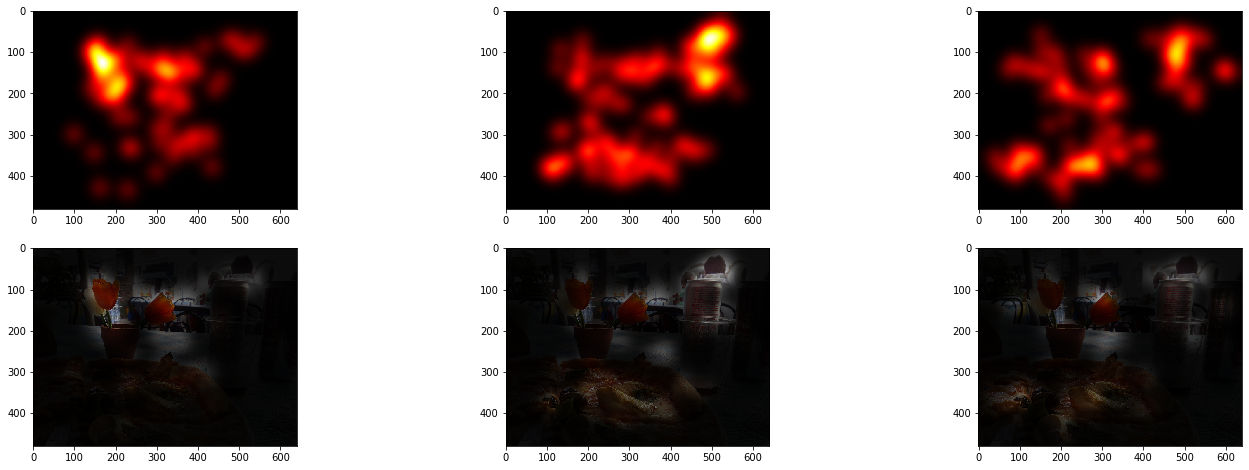

In [20]:
display_images(maps, image)

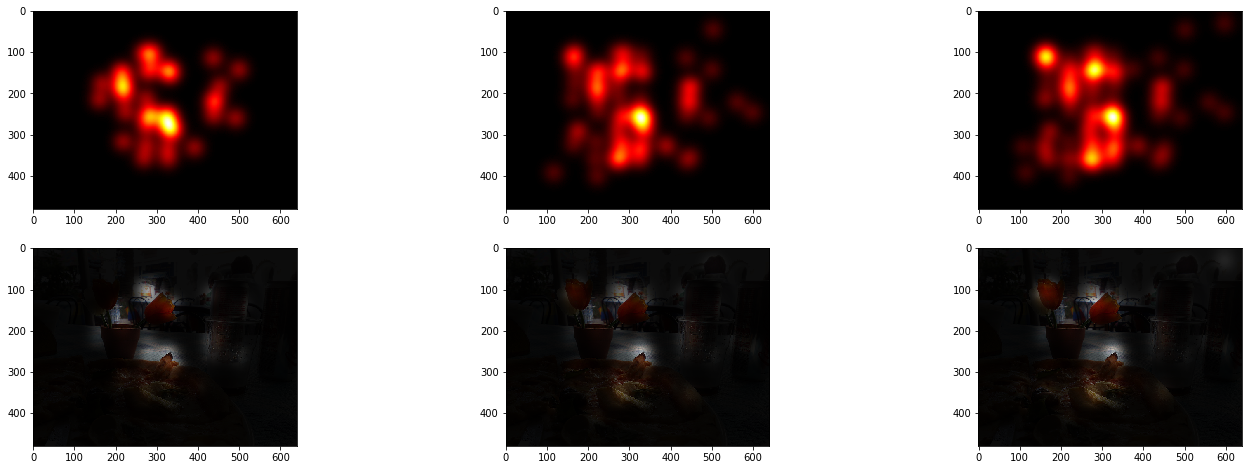

In [21]:
display_images(ground_truths, image)

### Generating ground truth heatmaps and fixations

In [ ]:
filenames = get_filenames(FIXATION_PATH + TRAIN_PATH)[:5000]
saliency_volumes, _ = get_saliency_volumes(filenames)

for i, saliency_volume in enumerate(tqdm(saliency_volumes)):
    fix_timestamps = np.array(sorted([fixation for fix_timestamps in saliency_volume
                                      for fixation in fix_timestamps], key=lambda x: (x[0])))
    sliced_fixations = split_fixations(fix_timestamps, [1000, 2500, 3500, 4000])[0::2]
    filename = filenames[i][:-3] + 'png'
    
    # Generating and saving heatmap
    maps = [create_image(bucket) for bucket in sliced_fixations]
    cv2.imwrite(GT_SLICE_PATH + TRAIN_PATH + '500/' + filename, 255 * maps[0] / maps[0].max())
    cv2.imwrite(GT_SLICE_PATH + TRAIN_PATH + '3000/' + filename, 255 * maps[1] / maps[1].max())
    cv2.imwrite(GT_SLICE_PATH + TRAIN_PATH + '5000/' + filename, 255 * maps[2] / maps[2].max())
    
    # Generating and saving fixations
    fixation_maps = [create_fixation_map(bucket) for bucket in sliced_fixations]
    cv2.imwrite(FIX_SLICE_PATH + TRAIN_PATH + '500/' + filename, 255 * fixation_maps[0] / fixation_maps[0].max())
    cv2.imwrite(FIX_SLICE_PATH + TRAIN_PATH + '3000/' + filename, 255 * fixation_maps[1] / fixation_maps[1].max())
    cv2.imwrite(FIX_SLICE_PATH + TRAIN_PATH + '5000/' + filename, 255 * fixation_maps[2] / fixation_maps[2].max())

# Saliency volumes

### Finding the right weights for timestamp matching

In [18]:
def get_mean_down_edge(saliency_volumes):

    down_edge = []

    for saliency_volume in saliency_volumes:
        fix_lengths = [len(f) for f in saliency_volume]
        max_length = np.max(fix_lengths)
        interpolated_timestamps = []

        for fix_timestamps in saliency_volume:
            if len(fix_timestamps) > 1:
                timestamps = [timestamp for timestamp, coord in fix_timestamps]
                interpolated_timestamps.append(interp.interp1d(np.arange(len(timestamps)),timestamps)
                                               (np.linspace(0,len(timestamps)-1,max_length)))

        down_edge.append(
            np.minimum(np.array([np.convolve([1, -1], it, 'valid') for it in interpolated_timestamps]), 0).mean())

    return -np.mean(down_edge) / TIMESPAN

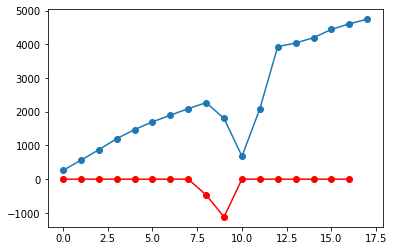

In [19]:
# Exemple for illustrating mean_down_edge

index = -11
saliency_volume = get_saliency_volumes(get_filenames(FIXATION_PATH + TRAIN_PATH)[0:1], progress_bar=False)[0][0]

fix_lengths = [len(f) for f in saliency_volume]
max_length = np.max(fix_lengths)
timestamps = [timestamp for timestamp, coord in saliency_volume[index]]
interpolated = interp.interp1d(np.arange(len(timestamps)),timestamps) \
                    (np.linspace(0,len(timestamps)-1,max_length))

plt.plot(np.array(interpolated), 'o-')
plt.plot(np.minimum(np.convolve([1, -1], interpolated, 'valid'), 0), 'ro-')

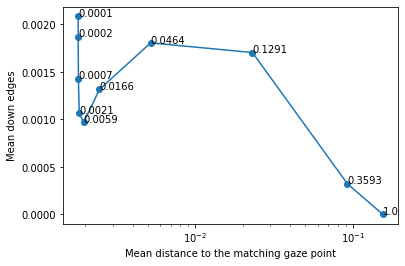

In [20]:
WEIGHT_SAMPLES = 500

filenames = np.random.choice(get_filenames(FIXATION_PATH + TRAIN_PATH), WEIGHT_SAMPLES, replace=False)
etws = np.logspace(-4, 0, 10)
me_scores = []
mde_scores = []

for etw in tqdm(etws):
    saliency_volumes, mean_error = get_saliency_volumes(filenames, etw=etw, progress_bar=False)
    mean_down_edge = get_mean_down_edge(saliency_volumes)
    
    me_scores.append(mean_error)
    mde_scores.append(mean_down_edge)
    
    
fig, ax = plt.subplots()
ax.plot(me_scores, mde_scores, "o-")
ax.set_xscale('log')

ax.set_xlabel('Mean distance to the matching gaze point', fontsize=10)
ax.set_ylabel('Mean down edges', fontsize=10)

for i, etw in enumerate(etws):
    ax.annotate(str(etw)[:6], (me_scores[i], mde_scores[i]))

### Saliency volume visualization

In [22]:
FRAME_NUMBER = 5

index = random.randint(0, TRAINING_SIZE - 1)
saliency_volume = get_saliency_volumes([get_filenames(FIXATION_PATH + TRAIN_PATH)[index]], progress_bar=False)[0][0]
image = imread(IMAGE_PATH + TRAIN_PATH + get_filenames(IMAGE_PATH + TRAIN_PATH)[index])

fix_timestamps = np.array(sorted([fixation for fix_timestamps in saliency_volume
                                  for fixation in fix_timestamps], key=lambda x: (x[0])))
maps = [create_image(bucket) for bucket in 
        split_fixations(fix_timestamps, np.linspace(0, 5000, FRAME_NUMBER + 1)[1:-1])]

print('Cumulated number of fixations:', fix_timestamps.shape[0])

Cumulated number of fixations: 440


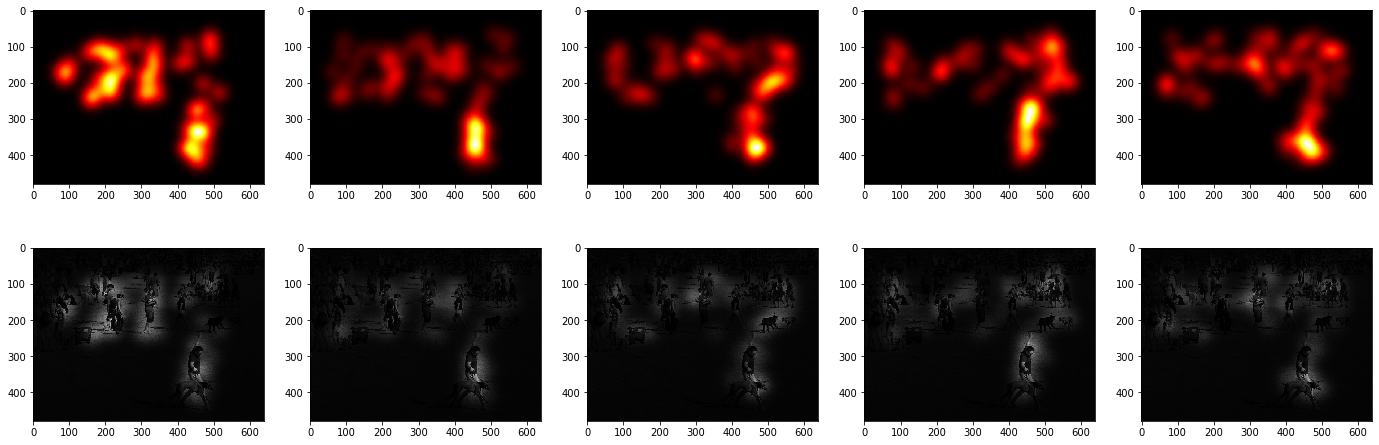

In [23]:
display_images(maps, image, True)

### Continuous saliency volume

In [42]:
from math import pi, sqrt, exp

def gauss(n, sigma):
    r = range(-int(n/2),int(n/2)+1)
    return [1 / (sigma * sqrt(2*pi)) * exp(-float(x)**2/(2*sigma**2)) for x in r]

In [61]:
filename = get_filenames(FIXATION_PATH + TRAIN_PATH)[random.randint(0, MDSEM_SIZE - 1)]
image = imread(IMAGE_PATH + TRAIN_PATH + filename[:-3] + 'jpg')
gt_map = imread(MAP_PATH + TRAIN_PATH + filename[:-3] + 'png')
saliency_volume = get_saliency_volumes([filename], progress_bar=False)[0][0]
fix_timestamps = np.array(sorted([fixation for fix_timestamps in saliency_volume
                                  for fixation in fix_timestamps], key=lambda x: (x[0])))
fix_timestamps = [(int(ts / 100), (x, y)) for (ts, (x, y)) in fix_timestamps]
temporal_map = np.zeros((50,H,W))

for ts, (x, y) in fix_timestamps:
    temporal_map[ts-1,y-1,x-1] = 1

for ts in tqdm(np.unique([ts for ts, _ in fix_timestamps])):
    temporal_map[ts-1] = ndimage.filters.gaussian_filter(temporal_map[ts-1], 30, mode='constant', cval=0)

In [62]:
for x in tqdm(range(W)):
    for y in range(H):
        #temporal_map[:,y,x] = signal.convolve(temporal_map[:,y,x], gauss(20, 1), mode='same', method='auto')
        temporal_map[:,y,x] = ndimage.gaussian_filter1d(temporal_map[:,y,x], 2, 0, mode='constant', cval=0)

temporal_map /= temporal_map.max()

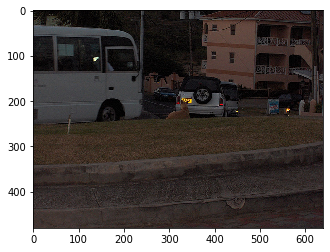

In [63]:
%matplotlib inline
plt.imshow(image)

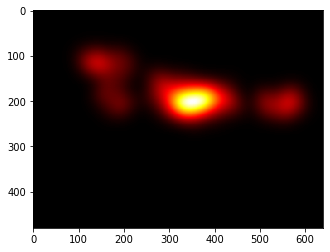

In [64]:
plt.imshow(get_heat_image(gt_map))

<IPython.core.display.Javascript object>


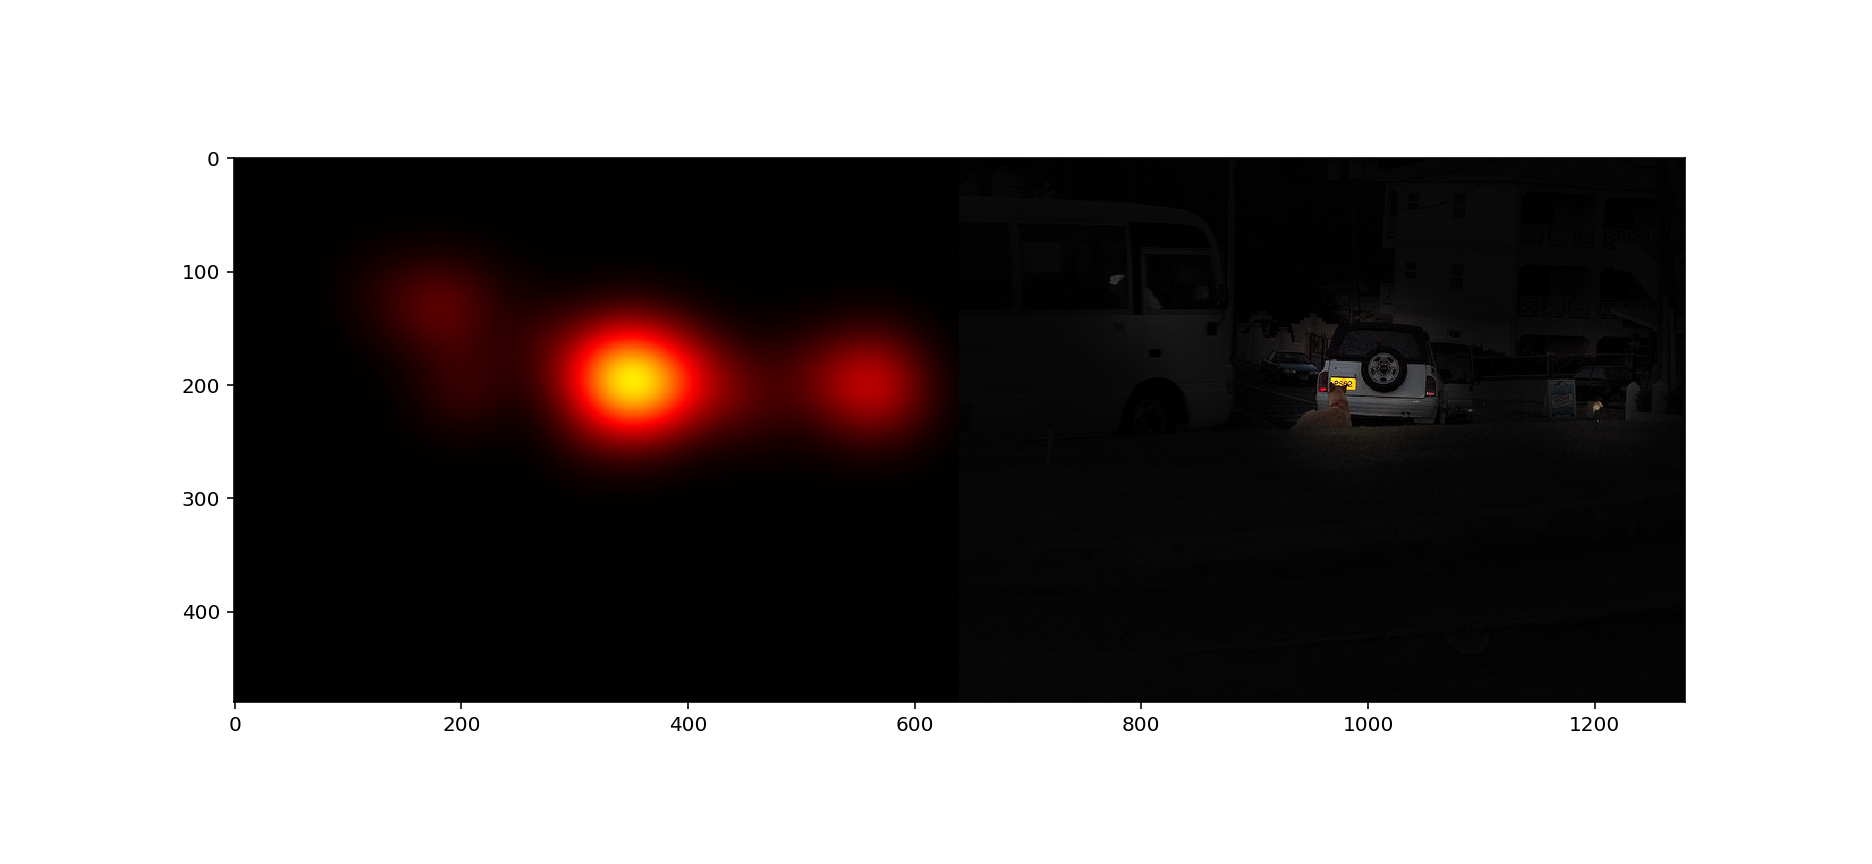

In [65]:
%matplotlib notebook
%matplotlib notebook

ani = animate(temporal_map, image, False)
ani.save('saliency_volume.gif', writer=animation.PillowWriter(fps=10))

In [ ]:
from mayavi import mlab

max_value = temporal_map.max()
[t, h, w] = temporal_map.shape
formatted_images = np.zeros((t, h, w, 3))
    
for i, map in enumerate(temporal_map):
    heatmap, image_heatmap = format_image(map, image, max_value)
    formatted_images[i] = heatmap

volume = mlab.pipeline.volume(mlab.pipeline.scalar_field(temporal_map), vmin=0, vmax=0.8)
#mlab.draw()
mlab.savefig('output.png')

<IPython.core.display.Javascript object>


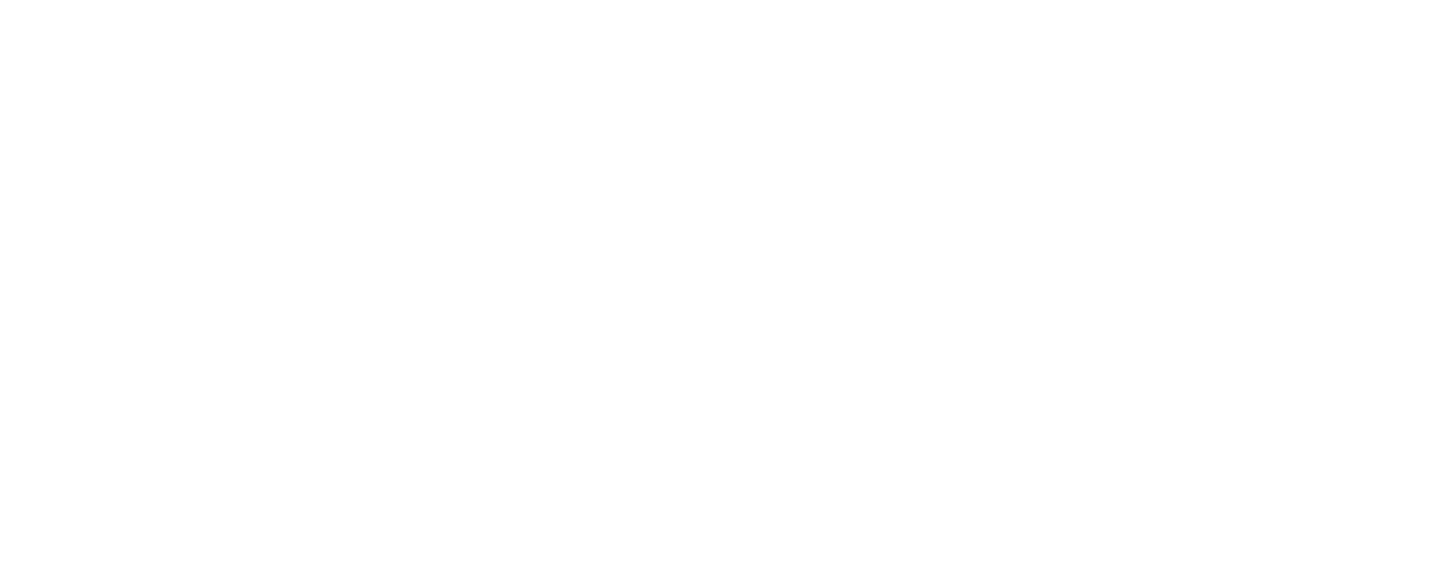

interactive(children=(IntSlider(value=0, description='i', max=49), Output()), _dom_classes=('widget-interact',…

<IPython.core.display.Javascript object>


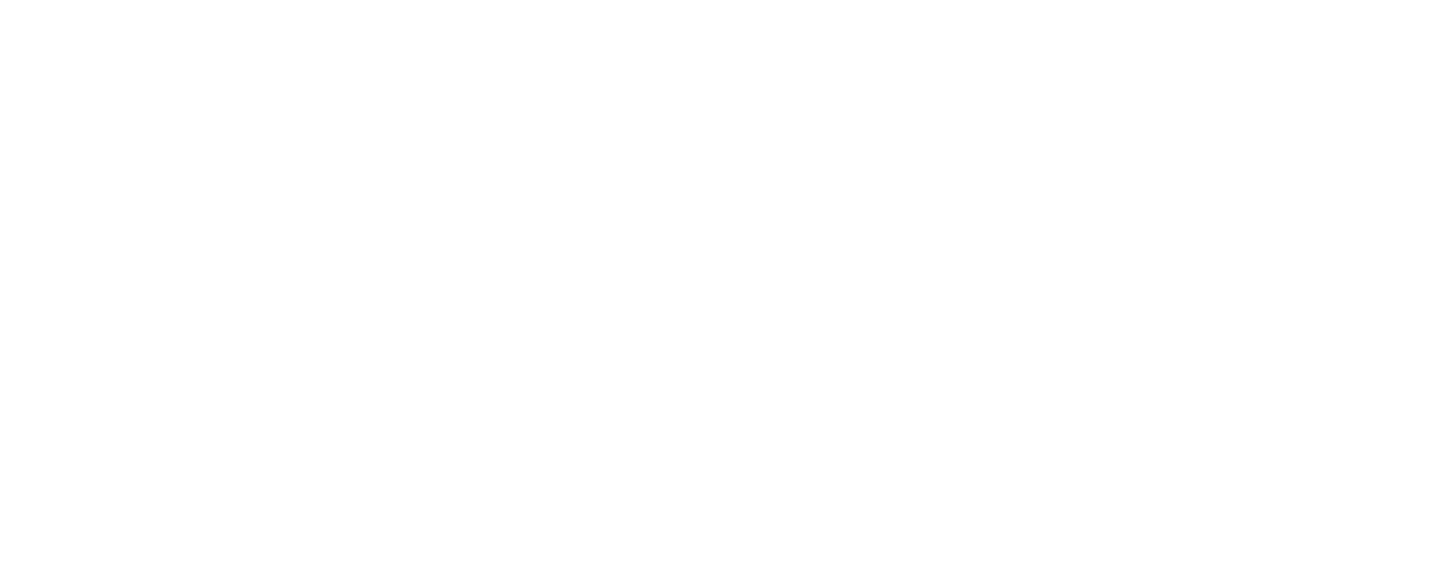

In [22]:
display_interactive(temporal_map, image, False)

### Relationship between saliency volumes and ground truths

In [18]:
REL_SAMPLES = 100

indices = random.sample(range(TRAINING_SIZE), REL_SAMPLES)
saliency_volumes, _ = get_saliency_volumes(np.array(get_filenames(FIXATION_PATH + TRAIN_PATH))[indices])

ground_truths = []
for filename in tqdm(np.array(get_filenames(MAP_PATH + TRAIN_PATH))[indices]):
    ground_truths.append(imread(MAP_PATH + TRAIN_PATH + filename))

In [19]:
x = np.array([], dtype='float')
y = np.array([], dtype='float')

for i in tqdm(range(REL_SAMPLES)):
    ground_truth = ground_truths[i]
    fix_timestamps = np.array(sorted([fixation for fix_timestamps in saliency_volumes[i]
                        for fixation in fix_timestamps], key=lambda x: (x[0])))
    
    x = np.concatenate((x, fix_timestamps[:,0].astype(dtype='float')))
    y = np.concatenate((y, np.array([ground_truth[y - 1, x - 1] for [timestamp, [x, y]] in fix_timestamps], dtype='float')))

In [20]:
# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

In [80]:
#wx = np.array([0, 250, 400, 640, 950, 1250, 1570, 2600, 3700, 5001], dtype='float')
#wy = np.array([0, 0.2, 0.45, 0.98, 1, 0.98, 0.67, 0.55, 0.47, 0.45], dtype='float')
#wx = np.array([0, 250, 400, 640, 950, 1250, 1570, 2600, 3700, 5001], dtype='float')
#wy = np.array([0, 0.2, 0.45, 0.98, 1, 0.98, 0.6, 0.45, 0.4, 0.4], dtype='float')
wx = np.array([0, 250, 400, 640, 950, 1250, 1570, 2600, 3700, 5001], dtype='float')
wy = np.array([0, 0.2, 0.45, 0.98, 1, 0.98, 0.85, 0.7, 0.65, 0.6], dtype='float')

wx = interp.interp1d(np.arange(len(wx)), wx)(np.linspace(0,len(wx)-1,20))
wy = interp.interp1d(np.arange(len(wy)), wy)(np.linspace(0,len(wy)-1,20))

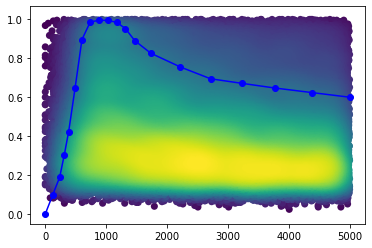

<Figure size 432x288 with 0 Axes>

In [81]:
fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=50, edgecolor='')
ax.plot(wx, wy, linestyle='-', marker='o', color='b')
plt.show()
plt.savefig('heatmap.png', bbox_inches='tight')

(-0.5, 550.5, 415.5, -0.5)

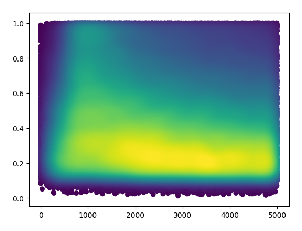

In [82]:
plt.imshow(imread('src/fixation_density_map.png'))
plt.axis('off')

In [83]:
def get_timestamp_weight(ts, wx, wy):
    idx = next(i for i, x in enumerate(wx) if x > ts)
    prev_x = wx[idx-1]
    next_x = wx[idx]
    range_x = (next_x - prev_x)
    
    prev_fac = (next_x - ts) / range_x
    next_fac = (ts - prev_x) / range_x
    return prev_fac * wy[idx-1] + next_fac * wy[idx]

In [137]:
index = random.choice(indices)
filename = get_filenames(FIXATION_PATH + TRAIN_PATH)[index]
saliency_volume = get_saliency_volumes([filename], progress_bar=False)[0][0]
image = imread(IMAGE_PATH + TRAIN_PATH + filename[:-3] + 'jpg')

print(len(saliency_volume), 'observers')

fix_timestamps = np.array(sorted([fixation for fix_timestamps in saliency_volume
                                  for fixation in fix_timestamps], key=lambda x: (x[0])))
fix_weights = [[get_timestamp_weight(ts, wx, wy), coord] for [ts, coord] in fix_timestamps]
wmap, twmap, _ = create_weighted_image(fix_weights)
maps = [imread(MAP_PATH + TRAIN_PATH + filename[:-3] + 'png'), 
        create_image(fix_timestamps[:,1]), wmap, twmap]

display_interactive(maps, image, True)

56 observers


interactive(children=(IntSlider(value=0, description='i', max=3), Output()), _dom_classes=('widget-interact',)…

In [138]:
maps = [maps[1], maps[3]]

display_interactive(maps, image, True)

interactive(children=(IntSlider(value=0, description='i', max=1), Output()), _dom_classes=('widget-interact',)…

### Evaluating weighted ground truth

In [163]:
EVAL_SAMPLES = 1000

indices = random.sample(range(TRAINING_SIZE), EVAL_SAMPLES)
filenames = np.array(get_filenames(FIXATION_PATH + TRAIN_PATH))[indices]
saliency_volumes, _ = get_saliency_volumes(filenames)
CC_scores = np.zeros(EVAL_SAMPLES)
noise = 0

for i, saliency_volume in enumerate(tqdm(saliency_volumes)):
    fix_timestamps = np.array(sorted([fixation for fix_timestamps in saliency_volume
                                      for fixation in fix_timestamps], key=lambda x: (x[0])))
    fix_weights = [[get_timestamp_weight(ts, wx, wy), coord] for [ts, coord] in fix_timestamps]
    _, wmap, wfix = create_weighted_image(fix_weights)
    omap = imread(MAP_PATH + TRAIN_PATH + filenames[i][:-3] + 'png')
    
    CC_scores[i] = CC(wmap, omap)
    noise += 1 - wfix.sum() / len(fix_weights)
    
print("Average CC: {:.5f}".format(CC_scores.mean()))
print("CC std: {:.5f}".format(CC_scores.std()))
print("Average filtered noise: {:.2f}%".format(100 * noise / EVAL_SAMPLES))


Average CC: 0.99887
CC std: 0.00134
Average filtered noise: 2.46%


### Generating weighted ground truth

In [168]:
def create_weighted_maps(path):
    filenames = get_filenames(FIXATION_PATH + path)[5000:]
    saliency_volumes, _ = get_saliency_volumes(filenames, path_prefix=path)

    for i, saliency_volume in enumerate(tqdm(saliency_volumes)):
        fix_timestamps = np.array(sorted([fixation for fix_timestamps in saliency_volume
                                          for fixation in fix_timestamps], key=lambda x: (x[0])))
        fix_weights = [[get_timestamp_weight(ts, wx, wy), coord] for [ts, coord] in fix_timestamps]
        filename = filenames[i][:-3] + 'png'

        # Generating and saving heatmap
        _, wmap, wfix = create_weighted_image(fix_weights)
        #wfix = create_weighted_fixation_map(fix_weights)
        
        cv2.imwrite(WMAP_PATH + path + filename, 255 * wmap / wmap.max())
        cv2.imwrite(WFIX_PATH + path + filename, 255 * wfix / wfix.max())

In [166]:
create_weighted_maps(TRAIN_PATH)

In [169]:
create_weighted_maps(TRAIN_PATH)

In [167]:
create_weighted_maps(VAL_PATH)

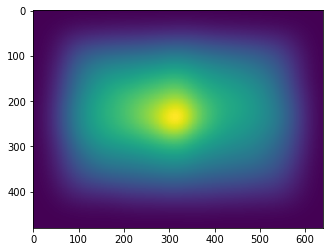

In [70]:
filenames = get_filenames(MAP_PATH + TRAIN_PATH)
maps = np.zeros((len(filenames), H, W))

for i, filename in enumerate(tqdm(filenames)):
    maps[i] = imread(MAP_PATH + TRAIN_PATH + filename)
    
plt.imshow(maps.mean(axis=0))

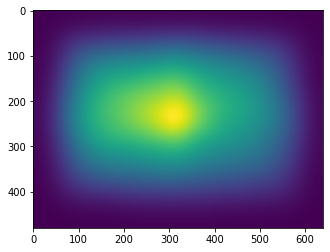

In [94]:
filenames = get_filenames(WMAP_PATH + TRAIN_PATH)
wmaps = np.zeros((len(filenames), H, W))

for i, filename in enumerate(tqdm(filenames)):
    wmaps[i] = imread(WMAP_PATH + TRAIN_PATH + filename)
    
plt.imshow(wmaps.mean(axis=0))

In [170]:
directory = 'data/submission/'
directory2 = 'data/submissionPNG/'

for filename in tqdm(sorted(os.listdir(directory))):
    if filename.endswith(".jpg"):
        img = imread(directory + filename)[:,:,0]
        #print(img.shape)
        name = filename[:-4] + '.png'
        cv2.imwrite(directory2 + name, img)
    else:
        continue